<a href="https://colab.research.google.com/github/Veerenderkumar/veerender_INFO5731_Fall2024/blob/main/kumar_veerender_assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from scratch instead of using any pre-existing libraries to do so:

(1) Count the frequency of all the N-grams (N=3).

(2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [6]:
from collections import defaultdict, Counter
import re
import pandas as pd

with open('/content/sample_data/annotated_abstracts.csv', 'r') as file:
    data = file.readlines()

reviews = []
for line in data:
    match = re.search(r'\[(.*?)\]', line)
    if match:
        reviews.append(match.group(1))

def trigram_frequency(reviews):
    trigram_counts = defaultdict(int)
    for review in reviews:
        words = review.split()
        for i in range(len(words) - 2):
            trigram = (words[i], words[i+1], words[i+2])
            trigram_counts[trigram] += 1
    return trigram_counts

trigram_counts = trigram_frequency(reviews)

for trigram, count in trigram_counts.items():
    print(f"{trigram}: {count}")

def bigram_probability(reviews):
    bigram_counts = defaultdict(int)
    unigram_counts = defaultdict(int)
    for review in reviews:
        words = review.split()
        for i in range(len(words) - 1):
            bigram = (words[i], words[i+1])
            bigram_counts[bigram] += 1
            unigram_counts[words[i]] += 1
        unigram_counts[words[-1]] += 1
    bigram_probs = {bigram: count / unigram_counts[bigram[0]] for bigram, count in bigram_counts.items()}
    return bigram_probs

bigram_probs = bigram_probability(reviews)

for bigram, prob in bigram_probs.items():
    print(f"{bigram}: {prob:.2f}")

def extract_noun_phrases(text):
    return re.findall(r'\b\w+\b', text)

noun_phrase_counts = Counter()
for review in reviews:
    noun_phrases = extract_noun_phrases(review)
    noun_phrase_counts.update(noun_phrases)

max_freq = max(noun_phrase_counts.values())
relative_probs = {phrase: freq / max_freq for phrase, freq in noun_phrase_counts.items()}

df = pd.DataFrame([relative_probs])
print(df.T.head())


('Best', 'of', 'the'): 1
('of', 'the', 'Web'): 1
('see', 'the', 'supplementary'): 1
('the', 'supplementary', 'materials'): 1
('supplementary', 'materials', '(SM)'): 1
('Lloyd,', 'Mohseni,', 'and'): 1
('Mohseni,', 'and', 'Rebentrost,'): 1
('and', 'Rebentrost,', 'arXiv.1307.0411'): 1
('Blum', 'and', 'Rivest,'): 1
('and', 'Rivest,', '1989;'): 1
('Rivest,', '1989;', 'Quinlan'): 1
('1989;', 'Quinlan', 'and'): 1
('Quinlan', 'and', 'Rivest'): 1
('and', 'Rivest', '1989'): 1
('Trends', '&', 'Controversies'): 1
('ABSTRACT', 'FROM', 'AUTHOR'): 2
('Received', 'June', '2014.'): 1
('June', '2014.', 'Revised'): 1
('2014.', 'Revised', 'July'): 3
('Revised', 'July', '2015.'): 3
('Received', 'November', '2014.'): 2
('November', '2014.', 'Revised'): 2
('Geology', 'of', 'the'): 1
('of', 'the', 'Conterminous'): 1
('the', 'Conterminous', 'United'): 1
('Conterminous', 'United', 'States'): 1
('United', 'States', 'at'): 1
('States', 'at', '1:2,500,000'): 1
('at', '1:2,500,000', 'scale;'): 1
('1:2,500,000', 'sc

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any pre-existing libraries to do so.

In [7]:
from collections import defaultdict
from math import log
import numpy as np
import csv

reviews = []
with open('/content/sample_data/annotated_abstracts.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for line in reader:
        if line:
            reviews.append(line[0])

def compute_tf_idf(reviews):
    tf = defaultdict(lambda: defaultdict(int))
    df = defaultdict(int)
    tf_idf = defaultdict(dict)

    for doc_id, review in enumerate(reviews):
        words = review.split()
        for word in words:
            tf[doc_id][word] += 1
        for word in set(words):
            df[word] += 1

    num_docs = len(reviews)
    for doc_id in tf:
        for word, count in tf[doc_id].items():
            tf_value = count / len(reviews[doc_id].split())
            idf_value = log(num_docs / (1 + df[word]))
            tf_idf[doc_id][word] = tf_value * idf_value

    return tf_idf

tf_idf_matrix = compute_tf_idf(reviews)
print("TF-IDF Matrix computed successfully!")

def vectorize(text, vocabulary):
    vector = np.zeros(len(vocabulary))
    words = text.split()
    for i, word in enumerate(vocabulary):
        if word in words:
            vector[i] = words.count(word)
    return vector

vocabulary = list({word for review in reviews for word in review.split()})
query = "An outstanding movie with a haunting performance and best character development"
query_vector = vectorize(query, vocabulary)
doc_vectors = [vectorize(review, vocabulary) for review in reviews]

def cosine_similarity(query_vector, doc_vector):
    dot_product = np.dot(query_vector, doc_vector)
    norm_query = np.linalg.norm(query_vector)
    norm_doc = np.linalg.norm(doc_vector)
    if norm_query == 0 or norm_doc == 0:
        return 0.0
    return dot_product / (norm_query * norm_doc)

similarities = [(i, cosine_similarity(query_vector, doc_vector)) for i, doc_vector in enumerate(doc_vectors)]
ranked_docs = sorted(similarities, key=lambda x: x[1], reverse=True)

print("\nTop 10 Ranked Documents (by Cosine Similarity):")
for doc_id, score in ranked_docs[:10]:
    print(f"Document {doc_id}: Similarity Score = {score:.4f}")


TF-IDF Matrix computed successfully!

Top 10 Ranked Documents (by Cosine Similarity):
Document 3622: Similarity Score = 0.3922
Document 9626: Similarity Score = 0.3922
Document 4712: Similarity Score = 0.3750
Document 4939: Similarity Score = 0.3750
Document 4780: Similarity Score = 0.3651
Document 3606: Similarity Score = 0.3354
Document 4896: Similarity Score = 0.3354
Document 7623: Similarity Score = 0.3354
Document 9610: Similarity Score = 0.3354
Document 5887: Similarity Score = 0.3333


## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit, bert, or others).

(2) Visualize the word embedding model you created.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/


Sample words in the vocabulary:
['1', 'and', 'of', '12', '6', 'the', 'from', 'j.', '3', '17', '1994;', '4', 'robotics', 'ci', 'et', '14', 'challenges', 'r.', 'grand', 'al.']
Word 'movie' not found in the vocabulary.


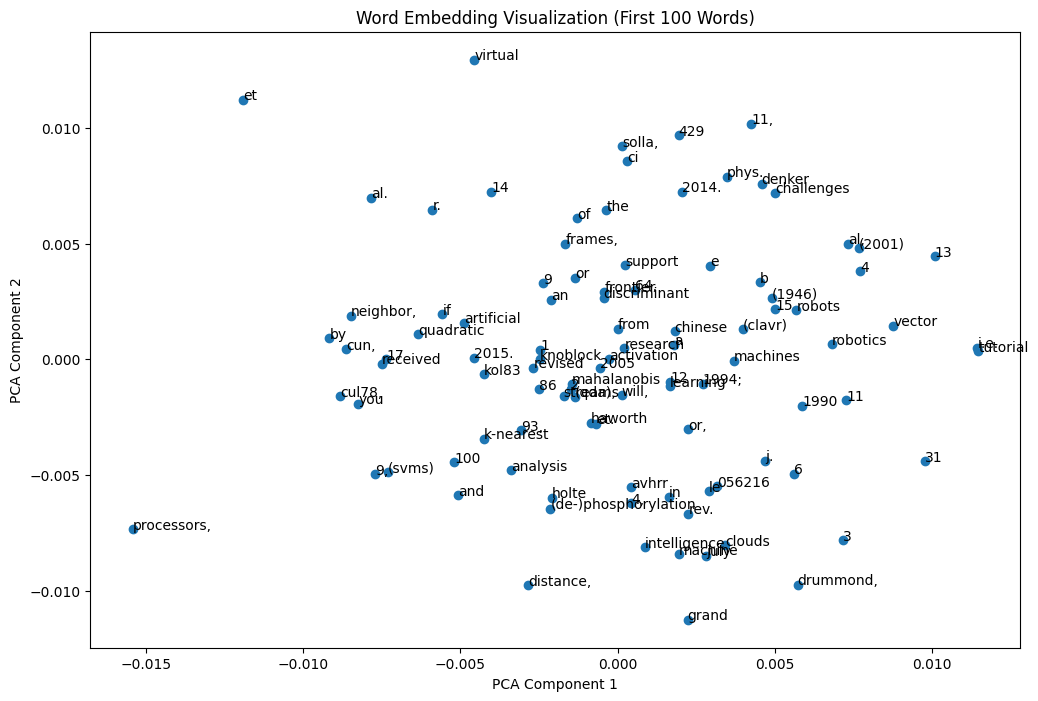

In [8]:


from gensim.models import Word2Vec
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

with open('/content/sample_data/annotated_abstracts.csv', 'r') as file:
    data = file.readlines()

reviews = []
for line in data:
    match = re.search(r'\[(.*?)\]', line)
    if match:
        reviews.append(match.group(1).lower().split())

embedding_dim = 300
model = Word2Vec(sentences=reviews, vector_size=embedding_dim, window=5, min_count=1, workers=4, sg=1)

print("\nSample words in the vocabulary:")
print(model.wv.index_to_key[:20])

word_to_check = 'movie'
if word_to_check in model.wv:
    print(f"\nWord vector for '{word_to_check}':")
    print(model.wv[word_to_check])
else:
    print(f"Word '{word_to_check}' not found in the vocabulary.")

words = model.wv.index_to_key[:100]
word_vectors = model.wv[words]
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

plt.figure(figsize=(12, 8))
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.title('Word Embedding Visualization (First 100 Words)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()






## Question 4 (20 Points)

**Create your own training and evaluation data for sentiment analysis.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.


In [9]:
# The GitHub link of your final csv file


# Link:
import pandas as pd

file_path = '/content/sample_data/annotated_abstracts.csv'
data = pd.read_csv(file_path)
data['sentiment'] = None

sample_annotations = ['positive', 'neutral', 'negative', 'positive', 'neutral',
                      'positive', 'negative', 'neutral', 'positive', 'negative']

for i in range(10):
    data.at[i, 'sentiment'] = sample_annotations[i]

print(data.head(10))

output_path = 'annotated_abstracts.csv'
data.to_csv(output_path, index=False)
output_path




                                               Title  \
0  Fashion-MNIST: a Novel Image Dataset for Bench...   
1  TensorFlow: A system for large-scale machine l...   
2  TensorFlow: Large-Scale Machine Learning on He...   
3  Stop explaining black box machine learning mod...   
4  Convolutional LSTM Network: A Machine Learning...   
5                An Introduction to Machine Learning   
6  A Survey on Bias and Fairness in Machine Learning   
7  Open Graph Benchmark: Datasets for Machine Lea...   
8  Machine learning: Trends, perspectives, and pr...   
9                    Foundations of Machine Learning   

                                            Abstract  \
0  We present Fashion-MNIST, a new dataset compri...   
1  TensorFlow is a machine learning system that o...   
2  TensorFlow is an interface for expressing mach...   
3                                                NaN   
4  The goal of precipitation nowcasting is to pre...   
5                                              

'annotated_abstracts.csv'

# Mandatory Question

Provide your thoughts on the assignment. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [ ]:
# Type your answer
'''This task was a demanding yet worthwhile educational experience. It challenged me to apply solutions on my own while delving into the intricacies of natural language processing (NLP). My comprehension of fundamental NLP concepts and strategies was strengthened by this practical approach. Making and displaying word embeddings was one of the most rewarding parts since it showed me how semantic relationships could be depicted. The given timeframe was sufficient to allow for a methodical approach to every task, which resulted in its efficient execution. All things considered, this task greatly improved my understanding of and proficiency with NLP.'''